In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, balanced_accuracy_score, log_loss, confusion_matrix,classification_report

In [6]:
%matplotlib inline
np.random.seed(42)
plt.rcParams['figure.figsize'] = 6, 6
df = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/DataAnalytics/master/dataset/Travel%20Insurance/travel%20insurance.csv")
columns_df = list(df.columns)
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


In [7]:
df.rename(columns={ 'Agency Type':'AgencyType', 'Distribution Channel':'DistChannel', 'Product Name':'ProdName',
                   'Net Sales':'NetSales', 'Commision (in value)':'Commission'},inplace=True)

In [8]:
print(df.info())
print(df.describe())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Agency       63326 non-null  object 
 1   AgencyType   63326 non-null  object 
 2   DistChannel  63326 non-null  object 
 3   ProdName     63326 non-null  object 
 4   Claim        63326 non-null  object 
 5   Duration     63326 non-null  int64  
 6   Destination  63326 non-null  object 
 7   NetSales     63326 non-null  float64
 8   Commission   63326 non-null  float64
 9   Gender       18219 non-null  object 
 10  Age          63326 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB
None
           Duration      NetSales    Commission           Age
count  63326.000000  63326.000000  63326.000000  63326.000000
mean      49.317074     40.702018      9.809992     39.969981
std      101.791566     48.845637     19.804388     14.017010
min       -2.000000   -389.000

In [9]:
df_cat=['Agency','AgencyType','DistChannel','ProdName','Destination']
for k in df_cat:
  print(k,':',df[k].unique())

Agency : ['CBH' 'CWT' 'JZI' 'KML' 'EPX' 'C2B' 'JWT' 'RAB' 'SSI' 'ART' 'CSR' 'CCR'
 'ADM' 'LWC' 'TTW' 'TST']
AgencyType : ['Travel Agency' 'Airlines']
DistChannel : ['Offline' 'Online']
ProdName : ['Comprehensive Plan' 'Rental Vehicle Excess Insurance' 'Value Plan'
 'Basic Plan' 'Premier Plan' '2 way Comprehensive Plan' 'Bronze Plan'
 'Silver Plan' 'Annual Silver Plan' 'Cancellation Plan'
 '1 way Comprehensive Plan' 'Ticket Protector' '24 Protect' 'Gold Plan'
 'Annual Gold Plan' 'Single Trip Travel Protect Silver'
 'Individual Comprehensive Plan' 'Spouse or Parents Comprehensive Plan'
 'Annual Travel Protect Silver' 'Single Trip Travel Protect Platinum'
 'Annual Travel Protect Gold' 'Single Trip Travel Protect Gold'
 'Annual Travel Protect Platinum' 'Child Comprehensive Plan'
 'Travel Cruise Protect' 'Travel Cruise Protect Family']
Destination : ['MALAYSIA' 'AUSTRALIA' 'ITALY' 'UNITED STATES' 'THAILAND'
 "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF" 'NORWAY' 'VIET NAM' 'DENMARK'
 'SINGAPORE'

In [10]:
print(df['Gender'].isnull().sum())
df.drop(columns=['Gender'],inplace=True)

45107


In [12]:
df['NetSales'] = df['NetSales'].apply(lambda x: 0 if x<0 else x)
df['Duration'] = df['Duration'].apply(lambda x: 0 if x<0 else x)
df.describe()

,Duration,NetSales,Commission,Age
count,63326.000000,63326.000000,63326.000000,63326.000000
mean,49.317168,41.354641,9.809992,39.969981
std,101.791520,47.573420,19.804388,14.017010
min,0.000000,0.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.530000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


In [13]:
df1=df.groupby(by=["Destination"]).size().reset_index(name="counts")
df1=df1.nlargest(20,['counts'])
dest_top = list(df1['Destination'])
df['Destination'] = df['Destination'].apply(lambda x: "OTHERS" if x not in dest_top else x)
df["Destination"].unique()

array(['MALAYSIA', 'AUSTRALIA', 'OTHERS', 'UNITED STATES', 'THAILAND',
       'VIET NAM', 'SINGAPORE', 'JAPAN', 'UNITED KINGDOM', 'INDONESIA',
       'INDIA', 'CHINA', 'TAIWAN, PROVINCE OF CHINA', 'PHILIPPINES',
       'MYANMAR', 'HONG KONG', 'KOREA, REPUBLIC OF', 'NEW ZEALAND',
       'BRUNEI DARUSSALAM', 'CAMBODIA', 'CANADA'], dtype=object)

In [14]:
df.columns

Index(['Agency', 'AgencyType', 'DistChannel', 'ProdName', 'Claim', 'Duration',
       'Destination', 'NetSales', 'Commission', 'Age'],
      dtype='object')

In [15]:
df.corr()

,Duration,NetSales,Commission,Age
Duration,1.000000,0.450057,0.344772,0.002474
NetSales,0.450057,1.000000,0.690139,0.039136
Commission,0.344772,0.690139,1.000000,0.118348
Age,0.002474,0.039136,0.118348,1.000000


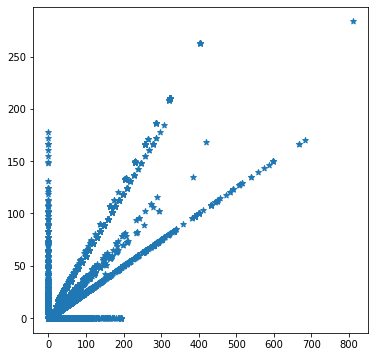

In [16]:
plt.scatter(x=df['NetSales'],y=df['Commission'],marker='*')

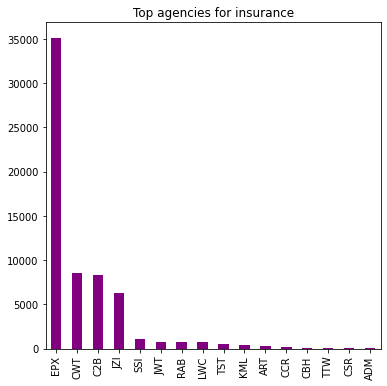

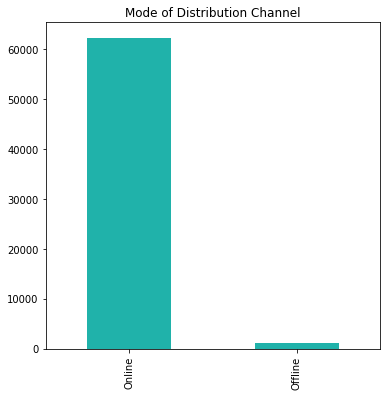

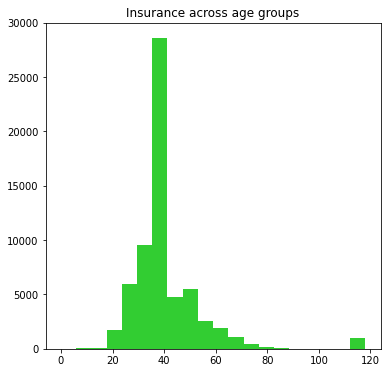

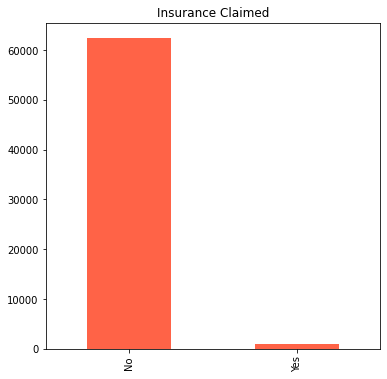

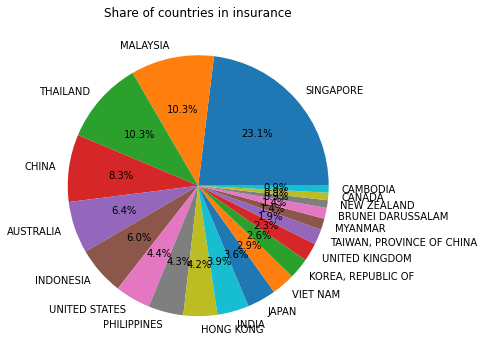

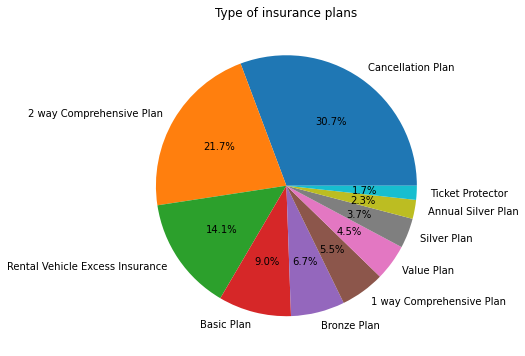

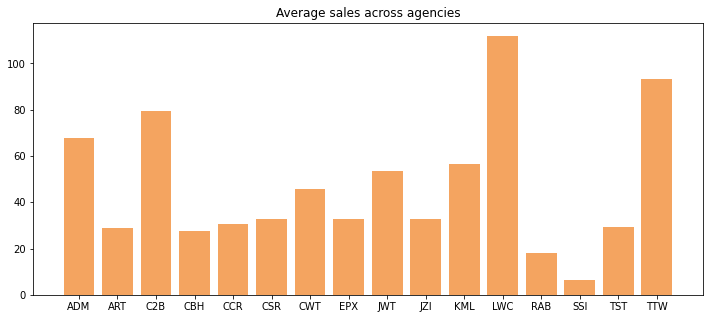

In [17]:
df['Agency'].value_counts().plot(kind='bar',color='purple')
plt.title('Top agencies for insurance')
plt.show()

df['DistChannel'].value_counts().plot(kind='bar',color='lightseagreen')
plt.title("Mode of Distribution Channel")
plt.show()

plt.hist(df['Age'],bins=20,color='limegreen')
plt.title("Insurance across age groups")
plt.show()

df['Claim'].value_counts()[:].plot(kind='bar',color='tomato')
plt.title('Insurance Claimed')
plt.show()

plt.pie(x=df1['counts'],labels=df1['Destination'],autopct='%1.1f%%')
plt.title('Share of countries in insurance')
plt.show()

df2=df.groupby(by=["ProdName"]).size().reset_index(name="counts")
df2=df2.nlargest(10,['counts'])
plt.pie(x=df2['counts'],labels=df2['ProdName'],autopct='%1.1f%%')
plt.title('Type of insurance plans')
plt.show()

dfplot=df.groupby(by=['Agency']).mean().reset_index()
plt.figure(figsize=(12, 5))
plt.bar(dfplot['Agency'],dfplot['NetSales'],color='sandybrown')
plt.title('Average sales across agencies')
plt.show()

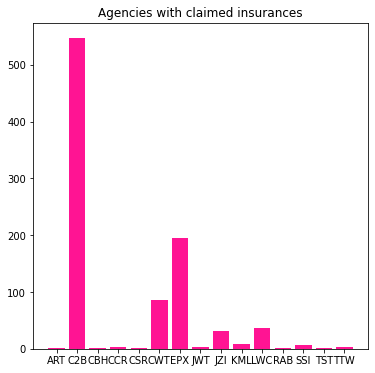

In [18]:
dfclaimed=df[df['Claim']=="Yes"]
dfplot=dfclaimed.groupby(by=["Agency"]).size().reset_index(name="counts")
plt.bar(dfplot['Agency'],dfplot['counts'],color='deeppink')
plt.title("Agencies with claimed insurances")
plt.show()

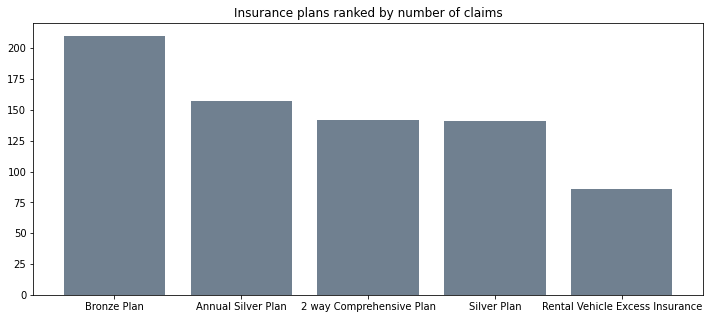

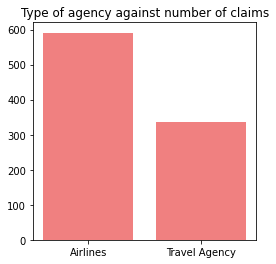

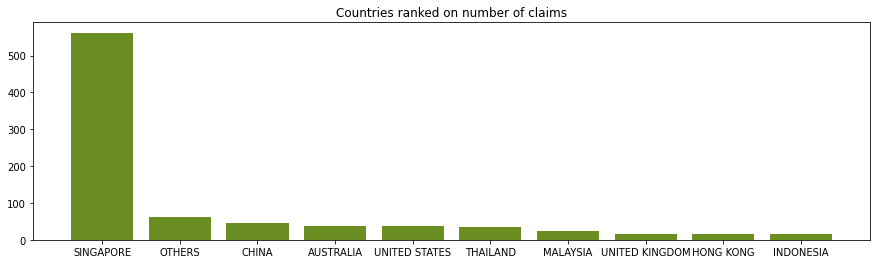

{'whiskers': [<matplotlib.lines.Line2D at 0x7f938370bdd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9383693490>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f938370bb10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9383693b50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9383693e90>],
 'means': []}

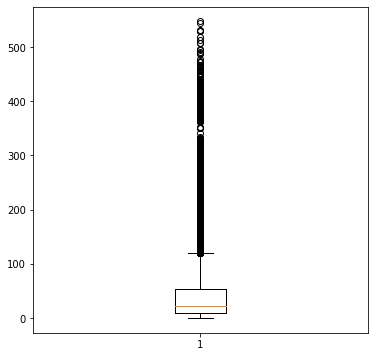

In [19]:
dfplot=dfclaimed.groupby(by=['ProdName']).size().reset_index(name="counts")
dfplot=dfplot.nlargest(5,['counts'])
plt.figure(figsize=(12, 5))
plt.bar(dfplot['ProdName'],dfplot['counts'],color='slategray')
plt.title('Insurance plans ranked by number of claims')
plt.show()

dfplot=dfclaimed.groupby(by=['AgencyType']).size().reset_index(name="counts")
dfplot=dfplot.nlargest(10,['counts'])
plt.figure(figsize=(4, 4))
plt.bar(dfplot['AgencyType'],dfplot['counts'],color='lightcoral')
plt.title('Type of agency against number of claims')
plt.show()

dfplot=dfclaimed.groupby(by=['Destination']).size().reset_index(name="counts")
dfplot=dfplot.nlargest(10,['counts'])
plt.figure(figsize=(15, 4))
plt.bar(dfplot['Destination'],dfplot['counts'],color='olivedrab')
plt.title('Countries ranked on number of claims')
plt.show()

df.drop(df[df['Duration']>700].index,inplace=True)
plt.boxplot(df['Duration'])

In [20]:
le_agency= LabelEncoder()
df['Agency'] = le_agency.fit_transform(df['Agency'])

le_agtype= LabelEncoder()
df['AgencyType'] = le_agency.fit_transform(df['AgencyType'])

le_dchannel= LabelEncoder()
df['DistChannel'] = le_agency.fit_transform(df['DistChannel'])

le_prodname= LabelEncoder()
df['ProdName'] = le_agency.fit_transform(df['ProdName'])

le_dest= LabelEncoder()
df['Destination'] = le_dest.fit_transform(df['Destination'])

le_claim= LabelEncoder()
df['Claim'] = le_claim.fit_transform(df['Claim'])
df.head(5)

,Agency,AgencyType,DistChannel,ProdName,Claim,Duration,Destination,NetSales,Commission,Age
0,3,1,0,12,0,186,10,0.0,9.57,81
1,3,1,0,12,0,186,10,0.0,9.57,71
2,6,1,1,16,0,65,0,0.0,29.70,32
3,6,1,1,16,0,60,0,0.0,23.76,32
4,6,1,1,16,0,79,13,0.0,11.88,41


In [21]:
X=df.drop(columns='Claim',inplace=False)
y=df['Claim']
sm = SMOTE(random_state=42)
Xb, yb = sm.fit_resample(X, y)
print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {Xb.shape}''')
print('\nBalance of positive and negative classes (%):')
yb.value_counts(normalize=True) * 100

Shape of X before SMOTE: (63311, 9)
Shape of X after SMOTE: (124768, 9)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: Claim, dtype: float64

In [22]:
scaler=MinMaxScaler()
cols_scaling = Xb.columns
Xb[cols_scaling]=scaler.fit_transform(Xb[cols_scaling])
X_train, X_test, y_train, y_test = train_test_split(Xb,yb,test_size=0.3,random_state=42,shuffle=True,stratify=yb)
values=[]
models = [RandomForestClassifier(),LogisticRegression(),DecisionTreeClassifier(random_state=42),SVC(),KNeighborsClassifier(),XGBClassifier()]
for m in models:
  m.fit(X_train,y_train)
  y_pred=m.predict(X_test)
  print(m)
  print(classification_report(y_test,y_pred)[1])
  print(confusion_matrix(y_test,y_pred))
  values.append([str(m)[:10],f1_score(y_test,y_pred), roc_auc_score(y_test,y_pred), recall_score(y_test,y_pred), precision_score(y_test,y_pred), 
      balanced_accuracy_score(y_test,y_pred), log_loss(y_test,y_pred)])
  print('==========================================================')

RandomForestClassifier()
 
[[17938   778]
 [  351 18364]]
LogisticRegression()
 
[[15770  2946]
 [ 5760 12955]]
DecisionTreeClassifier(random_state=42)
 
[[17800   916]
 [  577 18138]]
SVC()
 
[[15994  2722]
 [ 4977 13738]]
KNeighborsClassifier()
 
[[16508  2208]
 [  500 18215]]
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
 
[[17119  1597]
 [  

In [23]:
values.insert(0,['Model','f1_score','roc_auc_score','recall_score','precision_score','balanced_accuracy_score','log_loss'])
results= pd.DataFrame(values[1:],columns=values[0])
results[['Model','f1_score','roc_auc_score','recall_score']]

,Model,f1_score,roc_auc_score,recall_score
0,RandomFore,0.970177,0.969838,0.981245
1,LogisticRe,0.748498,0.767410,0.692225
2,DecisionTr,0.960470,0.960114,0.969169
3,SVC(),0.781123,0.794313,0.734064
4,KNeighbors,0.930809,0.927655,0.973283
5,XGBClassif,0.941697,0.940211,0.965749


In [24]:
results[['precision_score','balanced_accuracy_score','log_loss']]

,precision_score,balanced_accuracy_score,log_loss
0,0.959356,0.969838,1.041781
1,0.814729,0.767410,8.033367
2,0.951926,0.960114,1.377658
3,0.834629,0.794313,7.104171
4,0.891887,0.927655,2.498805
5,0.918814,0.940211,2.065108
